## **MobileNet CNN Model**

### **1. Import the necessary libraries**


In [11]:
# Import necessary libraries
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.10.1


### **2. Run the following codes with CUDA GPU enabled**


In [12]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


### **3. Building MobileNet Model**


In [13]:
def create_mobilenet_model(learning_rate=0.001, dropout_rate=0.0, dense_units=128):
    # Load pre-trained InceptionV4 model without top layers
    base_model = MobileNet(
        weights="imagenet", include_top=False, input_shape=(128, 128, 3)
    )

    # Freeze initial layers to keep pre-trained weights unchanged
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for MRI classification task
    x = GlobalAveragePooling2D()(base_model.output)
    if dropout_rate > 0.0:
        x = Dropout(dropout_rate)(x)
    x = Dense(dense_units, activation="relu")(x)
    if dropout_rate > 0.0:
        x = Dropout(dropout_rate)(x)
    predictions = Dense(4, activation="softmax")(x)

    # Create final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with specified learning rate
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

### **4. Train the Model**


In [14]:
# Define best parameters
learning_rate = 0.001
dropout_rate = 0.0
dense_units = 128
img_size = 128
batch_size = 12

# Store all models and histories
models = {}

# Define the paths
data_dir = "../DATASETS/kfold_dataset_128"  # Directory containing train, val, and test directories

# Iterate over the splits
for i in range(5):
    print(f"Fold {i + 1}")
    train_dir = data_dir + f"/train_fold_{i}"
    val_dir = data_dir + f"/val_fold_{i}"

    # ImageDataGenerator for data augmentation and normalization
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
    )

    val_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        batch_size=18,
        class_mode="categorical",
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(128, 128),
        batch_size=18,
        class_mode="categorical",
    )

    # Create model with current parameters
    model = create_mobilenet_model(
        learning_rate=learning_rate, dropout_rate=dropout_rate, dense_units=dense_units
    )

    # # Define callbacks
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=8, restore_best_weights=True
    )

    history = model.fit(
        train_generator,
        epochs=25,
        validation_data=val_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_steps=val_generator.samples // val_generator.batch_size,
        # callbacks=[early_stopping],
    )

    # Retrieve validation accuracy from history
    val_accuracy = max(history.history["val_accuracy"])
    val_loss = min(history.history["val_loss"])

    models[i] = {
        "model": model,
        "history": history.history,
        "val_accuracy": val_accuracy,
        "val_loss": val_loss,
    }

# Save the best model
highest_accuracy = 0
best_model = None
for key, value in models.items():
    if value["val_accuracy"] > highest_accuracy:
        highest_accuracy = value["val_accuracy"]
        best_model = value["model"]

# Save the best model
best_model.save("mobilenet_128_model_kfold.h5")

Fold 1
Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/25
21/21 [==============================] - 3s 88ms/step - loss: 1.0143 - accuracy: 0.5902 - val_loss: 0.5722 - val_accuracy: 0.7667
Epoch 2/25
21/21 [==============================] - 1s 54ms/step - loss: 0.5665 - accuracy: 0.7568 - val_loss: 0.5770 - val_accuracy: 0.7667
Epoch 3/25
21/21 [==============================] - 1s 59ms/step - loss: 0.4376 - accuracy: 0.8361 - val_loss: 0.5471 - val_accuracy: 0.7778
Epoch 4/25
21/21 [==============================] - 1s 56ms/step - loss: 0.3707 - accuracy: 0.8798 - val_loss: 0.5365 - val_accuracy: 0.7889
Epoch 5/25
21/21 [==============================] - 1s 58ms/step - loss: 0.3232 - accuracy: 0.8770 - val_loss: 0.6063 - val_accuracy: 0.7778
Epoch 6/25
21/21 [==============================] - 1s 59ms/step - loss: 0.2683 - accuracy: 0.9071 - val_loss: 0.4105 - val_accuracy: 0.8222
Epoch 7/25
21/21 [==============================] - 1s 55ms/step -

### **5. Evaluate and Visualize Results**


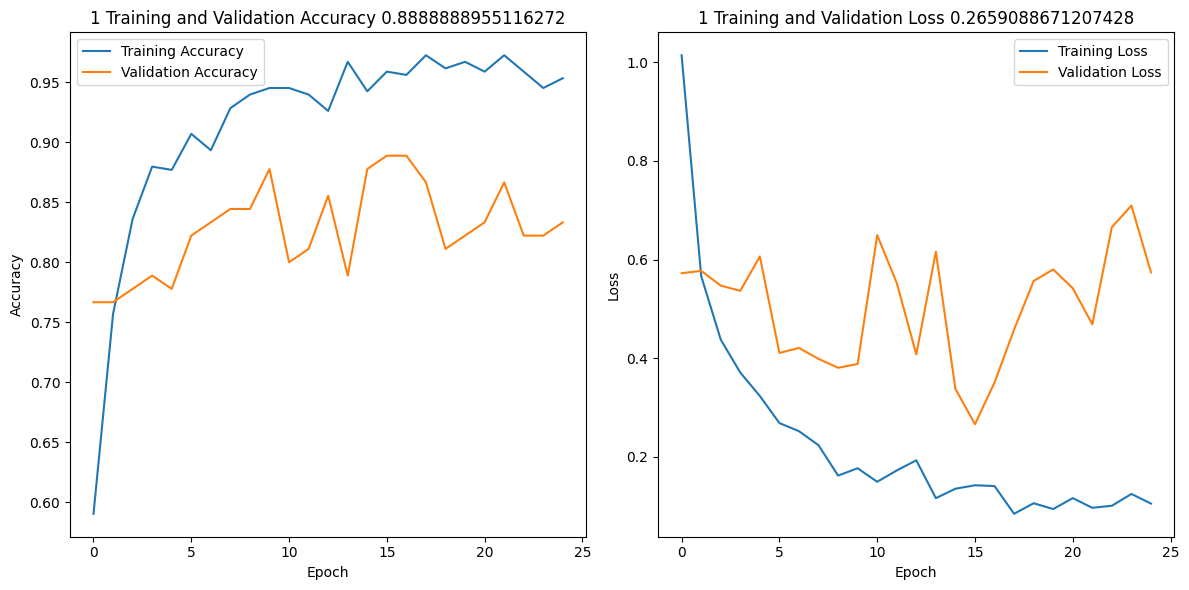

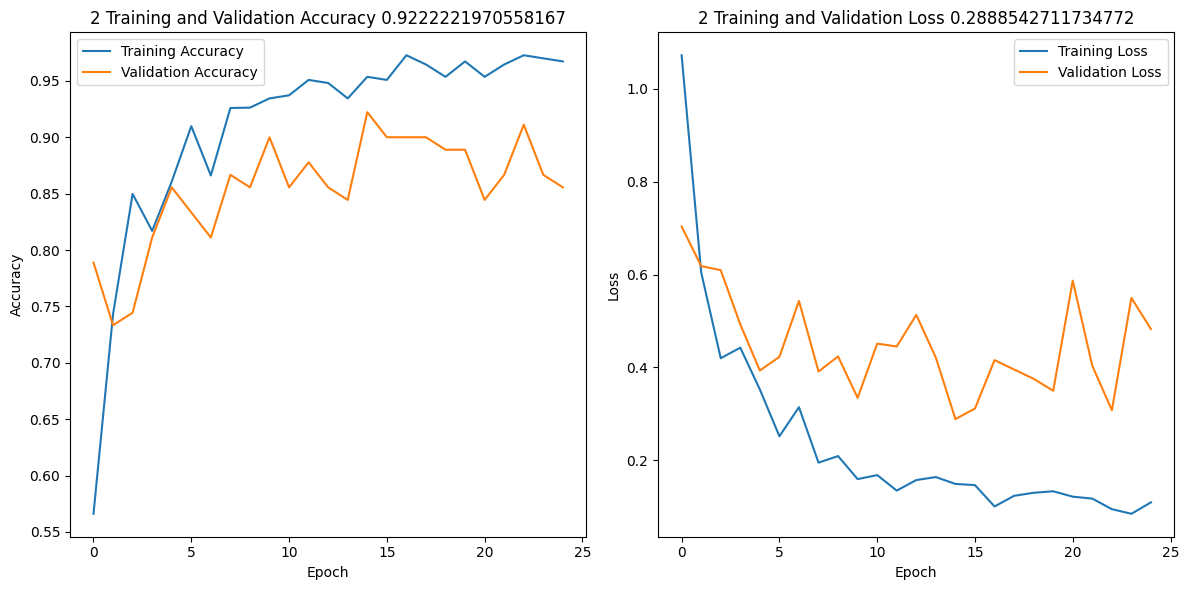

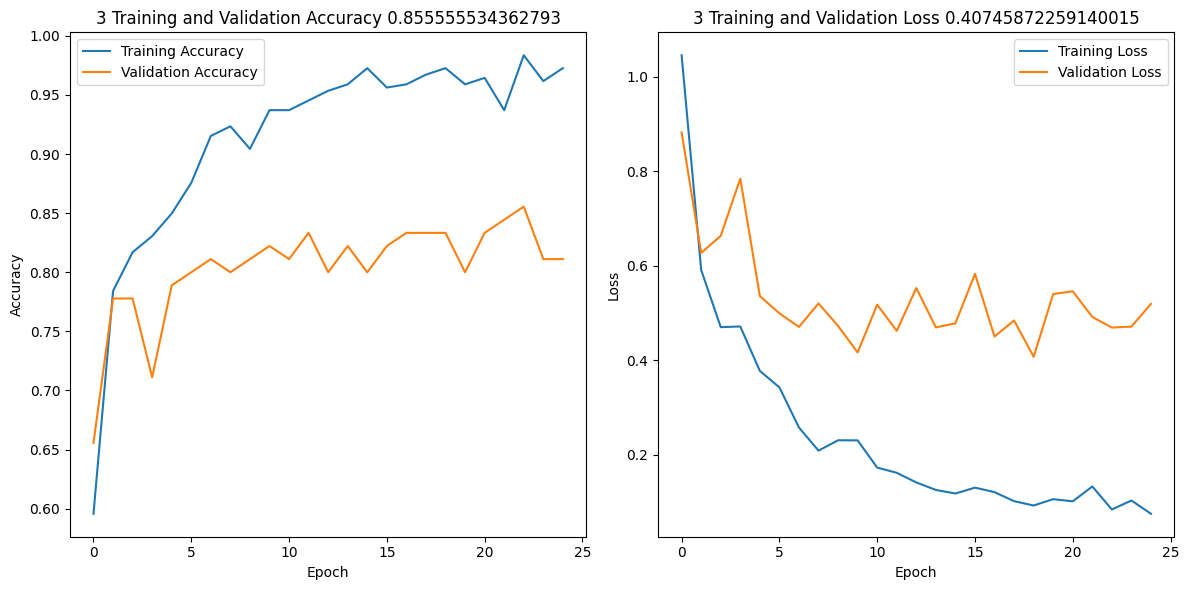

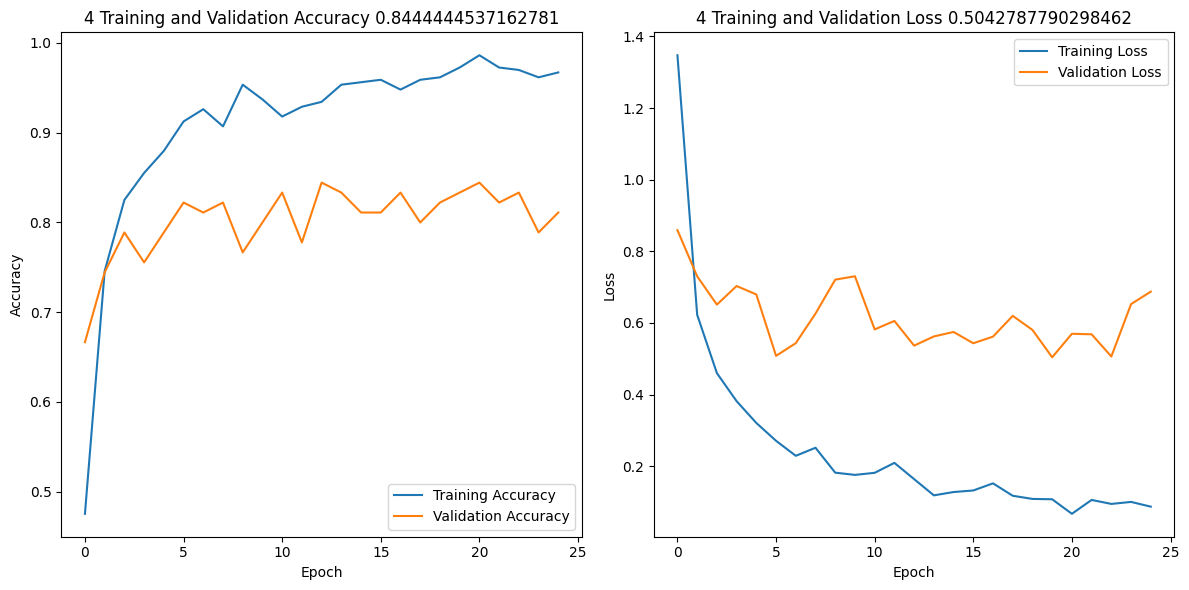

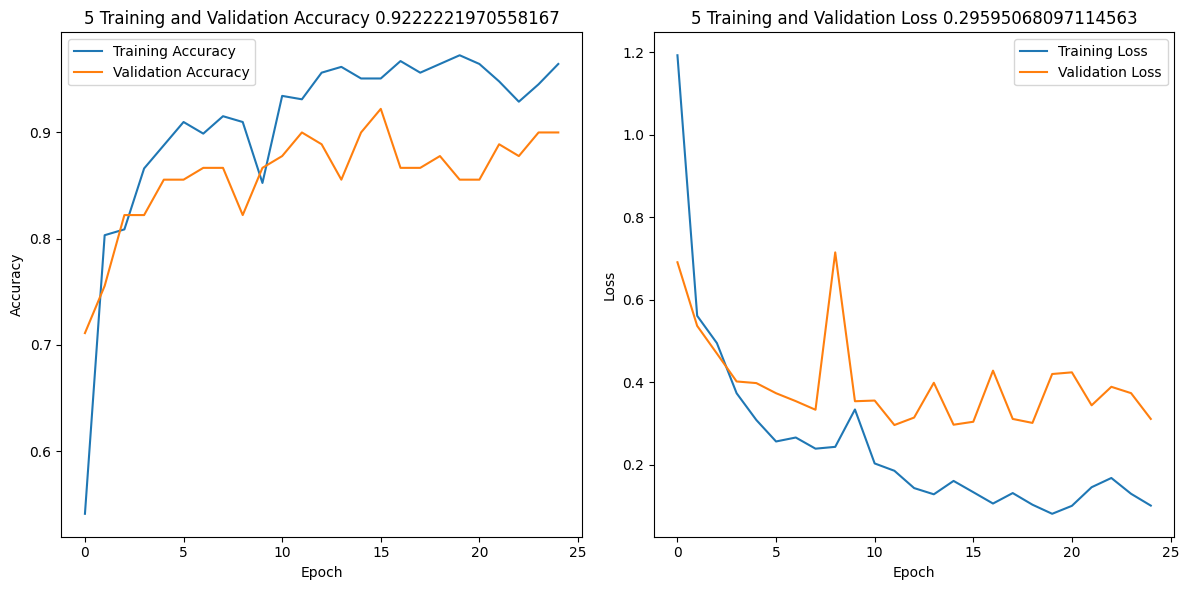

In [15]:
# Plot all training history
for key, value in models.items():
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(value["history"]["accuracy"], label="Training Accuracy")
    plt.plot(value["history"]["val_accuracy"], label="Validation Accuracy")
    plt.title(f"{ key + 1 } Training and Validation Accuracy { value['val_accuracy'] }")
    plt.xlabel("Epoch")
    plt.xticks([0, 5, 10, 15, 20, 25])
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(value["history"]["loss"], label="Training Loss")
    plt.plot(value["history"]["val_loss"], label="Validation Loss")
    plt.title(f"{ key + 1 } Training and Validation Loss { value['val_loss'] }")
    plt.xlabel("Epoch")
    plt.xticks([0, 5, 10, 15, 20, 25])
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()